In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from scipy import stats
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

import pickle

import matplotlib
#matplotlib.use('Agg')   # Use Agg backend to save figures
import matplotlib.pyplot as plt

##################################################
### GLOBAL VARIABLES
##################################################
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = '../../DDC_Data/wisdm/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

RANDOM_SEED = 60

# Data preprocessing
TIME_STEP = 60

# Model
N_CLASSES = 6
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration

# Hyperparameters
N_LSTM_LAYERS = 2
N_EPOCHS = 1
L2_LOSS = 0.0015
LEARNING_RATE = 0.0025

# Hyperparameters optimized
SEGMENT_TIME_SIZE = 180
N_HIDDEN_NEURONS = 30
BATCH_SIZE = 32



##################################################
### FUNCTIONS
##################################################

# Returns a tenforflow LSTM NN
# Input of shape (BATCH_SIZE, SEGMENT_TIME_SIZE, N_FEATURES)
def createLSTM(X):

        W = {
            'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_NEURONS])),
            'output': tf.Variable(tf.random_normal([N_HIDDEN_NEURONS, N_CLASSES]))
        }

        b = {
            'hidden': tf.Variable(tf.random_normal([N_HIDDEN_NEURONS], mean=1.0)),
            'output': tf.Variable(tf.Variable(tf.random_normal([N_CLASSES])))
        }

        # Transpose and then reshape to 2D of size (BATCH_SIZE * SEGMENT_TIME_SIZE, N_FEATURES)
        X = tf.transpose(X, [1, 0, 2])
        X = tf.reshape(X, [-1, N_FEATURES])

        hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + b['hidden'])
        hidden = tf.split(hidden, SEGMENT_TIME_SIZE, 0)

        # Stack two LSTM cells on top of each other
        lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_NEURONS, forget_bias=1.0)
        lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_NEURONS, forget_bias=1.0)
        lstm_layers = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2])

        outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

        # Get output for the last time step from a "many to one" architecture
        last_output = outputs[-1]

        return tf.matmul(last_output, W['output'] + b['output'])

##################################################
### MAIN
##################################################
if __name__ == '__main__':

    # LOAD DATA
    data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
    data['z-axis'].replace({';': ''}, regex=True, inplace=True)
    data = data.dropna()

    # SHOW GRAPH FOR JOGGING
    data[data['activity'] == 'Jogging'][['x-axis']][:50].plot(subplots=True, figsize=(16, 12), title='Jogging')
    plt.xlabel('Timestep')
    plt.ylabel('X acceleration (dg)')

    # SHOW ACTIVITY GRAPH
    activity_type = data['activity'].value_counts().plot(kind='bar', title='Activity type')
    plt.show()

    # DATA PREPROCESSING
    data_convoluted = []
    labels = []

    # Slide a "SEGMENT_TIME_SIZE" wide window with a step size of "TIME_STEP"
    for i in range(0, len(data) - SEGMENT_TIME_SIZE, TIME_STEP):
        x = data['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
        y = data['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
        z = data['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
        data_convoluted.append([x, y, z])

        # Label for a data window is the label that appears most commonly
        label = stats.mode(data['activity'][i: i + SEGMENT_TIME_SIZE])[0][0]
        labels.append(label)

    # Convert to numpy
    data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

    # One-hot encoding
    labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)
    print("Convoluted data shape: ", data_convoluted.shape)
    print("Labels shape:", labels.shape)

<Figure size 1600x1200 with 1 Axes>

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


Convoluted data shape:  (18301, 180, 3)
Labels shape: (18301, 6)


In [2]:
##### BUILD A MODEL
    # Placeholders
    X = tf.placeholder(tf.float32, [None, SEGMENT_TIME_SIZE, N_FEATURES], name="X")
    y = tf.placeholder(tf.float32, [None, N_CLASSES], name="y")

    y_pred = createLSTM(X)
    y_pred_softmax = tf.nn.softmax(y_pred, name="y_pred_softmax")

    # LOSS
    l2 = L2_LOSS * sum(tf.nn.l2_loss(i) for i in tf.trainable_variables())
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=y)) + l2

    # OPTIMIZER
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)
    correct_pred = tf.equal(tf.argmax(y_pred_softmax, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


In [3]:
# SPLIT INTO TRAINING AND TEST SETS
    X_train, X_test, y_train, y_test = train_test_split(data_convoluted, labels, test_size=0.3, random_state=RANDOM_SEED)
    print("X train size: ", len(X_train))
    print("X test size: ", len(X_test))
    print("y train size: ", len(y_train))
    print("y test size: ", len(y_test))


    

    # TRAINING
    saver = tf.train.Saver()

    history = dict(train_loss=[], train_acc=[], test_loss=[], test_acc=[])
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    train_count = len(X_train)

    for i in range(1, N_EPOCHS + 1):
        for start, end in zip(range(0, train_count, BATCH_SIZE), range(BATCH_SIZE, train_count + 1, BATCH_SIZE)):
            sess.run(optimizer, feed_dict={X: X_train[start:end], y: y_train[start:end]})

        _, acc_train, loss_train = sess.run([y_pred_softmax, accuracy, loss], feed_dict={X: X_train, y: y_train})
        _, acc_test, loss_test = sess.run([y_pred_softmax, accuracy, loss], feed_dict={X: X_test, y: y_test})

        history['train_loss'].append(loss_train)
        history['train_acc'].append(acc_train)
        history['test_loss'].append(loss_test)
        history['test_acc'].append(acc_test)

        if(i % 5 != 0):
            continue

        print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')


X train size:  12810
X test size:  5491
y train size:  12810
y test size:  5491


In [10]:
print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')

epoch: 1 test accuracy: 0.8357312083244324 loss: 0.7692234516143799


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [6]:
def show_conf_matrix(y_test, y_pred, labels):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=labels,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [7]:
def show_clf_report(y_test, y_pred, labels):
    print(classification_report(y_test, y_pred, target_names=labels))

final results: accuracy: 0.8357312083244324 loss: 0.7692234516143799


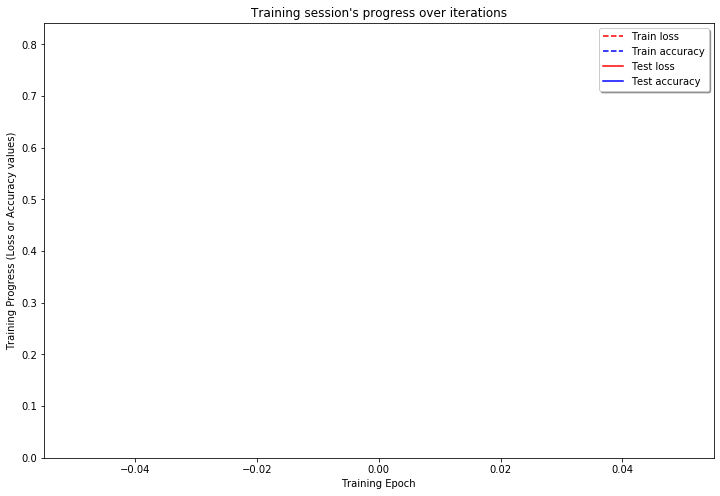

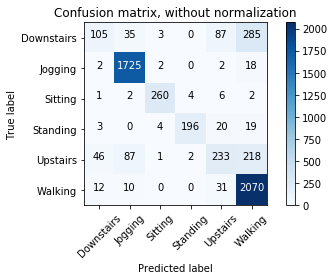

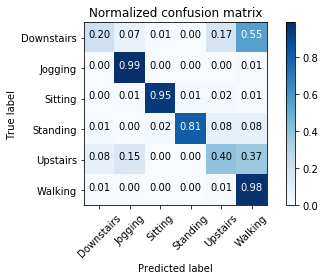

              precision    recall  f1-score   support

  Downstairs       0.62      0.20      0.31       515
     Jogging       0.93      0.99      0.96      1749
     Sitting       0.96      0.95      0.95       275
    Standing       0.97      0.81      0.88       242
    Upstairs       0.61      0.40      0.48       587
     Walking       0.79      0.98      0.87      2123

    accuracy                           0.84      5491
   macro avg       0.81      0.72      0.74      5491
weighted avg       0.82      0.84      0.81      5491



In [13]:
predictions, acc_final, loss_final = sess.run([y_pred_softmax, accuracy, loss], feed_dict={X: X_test, y: y_test})
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

    # PLOT GRAPHS
error_plot = plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "b--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "b-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)
#     error_plot.savefig('error_plot.png')
plt.show()


    # CONFUSION MATRIX
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
show_conf_matrix(y_test.argmax(axis=1), max_predictions, LABELS)
show_clf_report(y_test.argmax(axis=1), max_predictions, LABELS)
#     confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

#     plt.figure(figsize=(16, 14))
#     sns.heatmap(confusion_matrix/(np.sum(confusion_matrix, axis=1, keepdims=1)), xticklabels=LABELS, yticklabels=LABELS, annot=True);
#     plt.title("Confusion matrix")
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.show();